We are going to train an agent to drive a car on a simulated road. This is based on OpenAi Gym Race Car platform [here](https://worldmodels.github.io/) . This simulation can control a car by deciding left, right, break, and speed.


There are many methods/ implementation for this problem [see this page](https://medium.com/applied-data-science/how-to-build-your-own-world-model-using-python-and-keras-64fb388ba459) however, I will use encoder/decoder in TensorFlow to implement the code.

Following the Github page is an implementation based on the RNN model from the original paper. It is possible to customize this repository and build a model based on this repository, BUT as I mentioned, I'll use the **Autoencoder** method to solve this problem.

---

### Step 1- Generating training data: 
(script name: generate-data.py)

I'm generating training data from the 'generate-data.py' file; To generate the training data, we have to generate an 'observation', including 'positions', 'actions', 'rewards', and 'info'. 

here is 'agent-environment loop' that shows how it is works:

<img src="fl.svg">


Each timestep, the agent chooses an action, and the environment returns an observation and a reward.

Here is an overview of the function; NOTE: to generate the training data, you should run full code 'generate-data.py'

In [9]:
# software and packages for this kernel

#!git clone https://github.com/openai/gym.git
#!apt-get install -y libglu1-mesa-dev libgl1-mesa-dev libosmesa6-dev xvfb ffmpeg curl patchelf libglfw3 libglfw3-dev cmake zlib1g zlib1g-dev swig
#!pip install box2d box2d-kengz
#!pip install cma
#!pip install pyvirtualdisplay

#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

In [ ]:
#--------------------
# FULL script name: generate-data.py
# Here is just a snapshot of the main code
#-------------------

# generate action with mask 
def create_action(last_action):
    if np.random.randint(3) % 3:
        return last_action

    index = np.random.randn(3)
    index[1] = np.abs(index[1])
    index = np.argmax(index)
    mask = np.zeros(3)
    mask[index] = 1

    action = np.random.randn(3)
    action = np.tanh(action)
    action[1] = (action[1] + 1) / 2
    action[2] = (action[2] + 1) / 2

    return action*mask

# normalize numbers  
def norm_obse(observation):
    return observation.astype('float32') / 255.

def simulate_batch(batch_num):
    car_env = CarRacing()

    obs_data = []
    action_data = []
    action = car_env.action_space.sample()
    for item in range(batch_size):
        en_observ = env.reset()
        # this make car to start in random positions 
        position = np.random.randint(len(car_env.track))
        car_env.car = Car(car_env.world, *car_env.track[position][1:4])
        en_observ = norm_obse(en_observ)

        obs_sequence = []

        # time steps
        for i in range(steps):
            if render:
                car_env.render()

            action = create_action(action)
            en_observ, reward, done, info = car_env.step(action)
            en_observ = norm_obse(en_observ)

            obs_data.append(en_observ)

    print("Saving dataset for batch {}".format(batch_num))
    np.save('data/TR_data_{}'.format(batch_num), obs_data)
    car_env.close()

Here we can run the "generate-data.py" to start to generate the training data:

In [2]:
#!python generate-data.py

Generating data for env CarRacing-v0
/opt/conda/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/opt/conda/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Track generation: 1162..1457 -> 295-tiles track
Track generation: 1161..1455 -> 294-tiles track
Track generation: 1297..1625 -> 328-tiles track
Track generation: 1016..1274 -> 258-tiles track
Track generation: 1123..1408 -> 285-tiles track
Track generation: 1319..1653 -> 334-tiles track
Track generation: 1433..1795 -> 362-tiles track
Track generation: 1151..1443 -> 292-tiles track
Track generation: 1098..1377 -> 279-tiles track
Track generation: 1159..1460 -> 301-tiles track
Track generation: 1103..1383 -> 280-tiles track
Track generation: 1284..1609 -> 325-tiles track
T

---

### Step 2: Training model

(script name: train_model.py)

The implementation of the method based on Autoencode whcih is based on this paper and it's quite stright forward to implement by tensorflow [Link to the paper](https://arxiv.org/pdf/1803.10122.pdf)

In this file, we train the model from scratch until the loss function lower than the defined value. 

I'm using Titan RTX to train the model, so for me, it took just a few minutes to train it. 

Also, you can monitor the training from the tensorboard and log director (tensorboard --logdir logdir)

<img src="car.png">

---

here is the summary of Network Architecture: 

**Encoder**:

| Input shape     | GPU trained                                                                       |
|-----------------|-----------------------------------------------------------------------------------|
| (64, 64, 3)   | Convolutional 2D, 4x4 kernels, stride 2, ReLU activation, Weight regularization   |
| (31, 31, 32) |  ReLU conv (32, 4), stride 2, Weight regularization
| (14, 14, 64) | ReLU conv (64, 4), stride 2,  Weight regularization   |
| (6, 6, 128) | ReLU conv (128, 4) , stride 2, ReLU activation, Weight regularization   |
| (64, 256) | ReLU conv (256, 4), Weight regularization   |
| (2, 2, 256) | output  |

**Decoder**

| Input shape     | GPU trained                                                                       |
|-----------------|-----------------------------------------------------------------------------------|
| (1, 1, 1024)   | transpose arrays , dense layer   |
| (5, 5, 128) |  DeConvolutional (128, 5), stride 2, Weight regularization
| (13, 13, 64) | ReLU deconv (64, 5), stride 2,  Weight regularization   |
| (30, 30, 32) | ReLU deconv (32, 6) , stride 2, Weight regularization   |
| (64, 64, 3) | output sigmoid deconv (3,6)  |

---

### Train the agent from the expert data
(full script: train_agent.py)

In order to drive the car around, the agent needs to output 3 values:


| Action type     | Range          | 
|-----------------|-----------------------|
| Steering   | [-1, 0 or 1]  |
| Acceleration| [0 or 1] |
| Brake | [0 or 0.5]   |

But the point is when the car braking means accelerating useless so agent output, in this case only two parameters that end up with learning time.


Because the action is dependent only on the current observation, the number of parameters is:
Embedding_size * 2 + bias = 66


In [ ]:
#--------------------
# FULL script name: train_agent.py
# this is just snapshut from the train_agent.py
#-------------------
def decide(sess, network, observation, params):
    observation = nrm_obs(observation)
    embedding = sess.run(network.z, feed_dict={network.image: observation[None, :,  :,  :]})
    weights, bias = weight_bias(params)

    action = np.zeros(num_act)
    predict = np.matmul(np.squeeze(embedding), weights) + bias
    predict = np.tanh(predict)

    action[0] = predict[0]
    if predict[1] < 0:
        action[1] = np.abs(predict[1])
        action[2] = 0
    else:
        action[2] = predict[1]
        action[1] = 0

    return action

The training uses stochastic optimizer class (CMA-ES)  to learn the 66 parameters.

In the method paper they used 64 agents each evaluated on 16 trials. But because of the training time I'm running with low number to speedup the training. 

In [ ]:
def train():
    # CMA-ES stochastic optimizer class with ask-and-tell interface.
    sto = cma.CMAEvolutionStrategy(num_par * [0], 0.1, {'popsize': 10})# if you have more memory feel free to increase it
    rewards_through_gens = []
    generation = 1
    try:
        while not sto.stop():
            solutions = sto.ask()
            # this is multi processing  
            with mp.Pool(mp.cpu_count()) as parallel:
                rewards = list(tqdm.tqdm(parallel.imap(play, list(solutions)), total=len(solutions)))
            sto.tell(solutions, rewards)
            rewards = np.array(rewards) *(-1.)
            generation+=1
            rewards_through_gens.append(rewards)
            np.save('rewards', rewards_through_gens)

    except (KeyboardInterrupt, SystemExit):
        print("Manual Interrupt")
    except Exception as e:
        print("Exception: {}".format(e))
    return sto

Each agent is running in a different process, and the reward they get is an average over 10 trials.

If you need to know why multiple trials using here, [check this blog](http://blog.otoro.net/2017/11/12/evolving-stable-strategies/), which explains the Evolving Stable Strategies.

Finally we can start to train the agent: 

In [10]:
!python train_agent.py

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.



Track generation: 1148..1448 -> 300-tiles track


---

### Results:

After a few hours and running for 200 generation the best agent can get an average reward of ~550 

Text(0, 0.5, 'Reward')

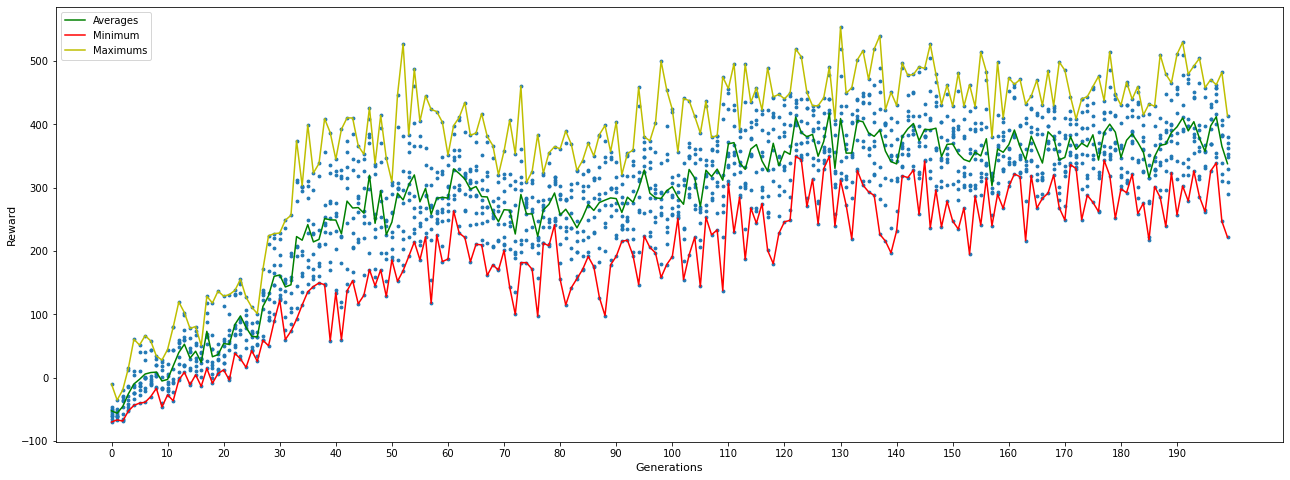

In [5]:
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    import seaborn as sns
    rewards = list(np.load('rewards.npy'))
    rewards = np.array(rewards)
    #rewards=rewards[1:500]
    x = np.linspace(0, len(rewards)-1, len(rewards)).repeat(rewards.shape[1])

    mean = np.mean(rewards, axis=1)
    mx = np.max(rewards, axis=1)
    mn = np.min(rewards, axis=1)
    fig = plt.figure(figsize=(22, 8))
    ax = fig.add_subplot(111)

    ax.scatter(x, rewards.flatten(), s=8)
    ax.plot(mean, c='g', label='Averages')
    ax.plot(mn, c='r', label='Minimum')
    ax.plot(mx, c='y', label='Maximums')

    plt.legend(loc='upper left')

    plt.xlabel('Generations', fontsize=11)
    plt.xticks(np.arange(min(x), max(x)+1, 10))

    plt.ylabel('Reward', fontsize=11)



# summary:

As I explained in the beginning, we could use other algorithms for this problem, such as RNN/ Deep Q, and implementation already available in Github. For instance, if we use the RNN model, it's possible to predict the probability of being killed in the next time-step, but it needs more time to train and implement. 

We could improve the reward score by adjusting hyperparameters in our network, but the current reward score is not bad for the few hours of training. 

<img src="rand.gif">